In [1101]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing.imputation import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
import random
import matplotlib.pyplot as plt

In [1102]:
def makeUserTarget(df, user):
    aux = []
    for _, row in df.iterrows():
        if row.our_data == 0:
            if(np.floor(row.SessionID/100).astype(int) == user):
                aux.append(1)
            else:
                aux.append(0)
        else:
            if 'Diego' in row.SessionID and user == 'Diego':
                aux.append(1)
            elif 'Toto' in row.SessionID and user == 'Toto':
                aux.append(1)
            elif (('Jo' in row.SessionID) or ('jo' in row.SessionID)) and user == 'Jo':
                aux.append(1)
            else:
                aux.append(0)
    df['target'] = aux

In [1103]:
def separateIntoTrainAndTest(df, test_sessions = []):
    targetSessionIds = list(df[df.target == 1].SessionID.unique())
    targetChoosenSession = random.choice(targetSessionIds)
    notTargetSessionIds = list(df[df.target == 0].SessionID.unique())
    notTargetChoosenSessions = test_sessions
    for i in range(2):
        notTargetChoosenSession = random.choice(notTargetSessionIds) 
        notTargetChoosenSessions.append(notTargetChoosenSession)
        notTargetSessionIds.remove(notTargetChoosenSession)
    df_train = df[(df.SessionID != targetChoosenSession) & (~df.SessionID.isin(notTargetChoosenSessions))]
    df_test = df[(df.SessionID == targetChoosenSession) | (df.SessionID.isin(notTargetChoosenSessions))]
    
    return df_train, df_test

In [1104]:
def getOurDataUsers(row):
    if 'Diego' in row.SessionID :
        return('Diego')
    elif 'Toto' in row.SessionID:
        return('Toto')
    elif ('Jo' in row.SessionID) or ('jo' in row.SessionID):
        return('Jo')

In [1105]:
file_name = '../aggregated_features'
our_data_file_name = '../our_data_aggregated_features'
to_drop = []
df = pd.read_csv('./' + file_name + '.csv')
our_data_df = pd.read_csv('./' + our_data_file_name + '.csv')
df['our_data'] = 0
our_data_df['our_data'] = 1

In [1106]:
users = (np.floor(df.SessionID/100).astype(int)).unique()
our_data_users = our_data_df.apply(getOurDataUsers,axis=1)

In [1107]:
df = df.append(our_data_df,ignore_index=True)

In [1110]:
df.head(5).T

,0,1,2,3,4
Acc_X_mean,-0.098425,-0.260413,-0.470253,-0.400509,-0.281103
Acc_X_std,0.205794,0.213283,0.344431,0.446145,0.267981
Acc_Y_mean,7.59366,7.78017,7.90233,7.92856,8.26282
Acc_Y_std,0.273463,0.124979,0.201373,0.165316,0.205305
Acc_Z_mean,5.4353,5.21084,5.0256,5.01316,4.53329
Acc_Z_std,0.416557,0.477423,0.609417,0.394647,0.404194
Contact_size_mean,NaN,NaN,NaN,NaN,NaN
Contact_size_std,NaN,NaN,NaN,NaN,NaN
Deltas_0_mean,232,233.5,203.2,262,249
Deltas_0_median,232,236.5,218,262,249


In [1084]:
df = df[df.our_data != 0]

In [1085]:
#user = random.choice(users)
user = 'Toto'
makeUserTarget(df, user)

In [1086]:
#to_drop =  ['our_data','Contact_size_mean','Contact_size_std'] 
to_drop =  ['our_data','Mag_Z_mean','Mag_X_mean','Mag_Y_mean','Mag_Y_std','Mag_Z_std','Mag_X_std']

In [1087]:
clf = xgb.XGBClassifier(n_estimators=90, max_depth=9, random_state=31, colsample_bytree=0.6, colsample_bylevel=0.5, learning_rate=0.11, subsample=0.9)
#clf = RandomForestClassifier()

In [1088]:
df_train, df_test = separateIntoTrainAndTest(df)

In [1089]:
df_train = df_train.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)
df_test = df_test.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)

In [1090]:
x_train, y_train = df_train.drop("target", axis=1), df_train["target"]

In [1091]:
clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.6, gamma=0, learning_rate=0.11, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=31, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [1092]:
i_pred_proba = clf.predict_proba(x_train)

In [1093]:
auc = roc_auc_score(y_train, i_pred_proba[:, 1])
print(auc)

1.0


In [1094]:
x_test, y_test = df_test.drop("target", axis=1), df_test["target"]

In [1095]:
predict = clf.predict_proba(x_test)

In [1096]:
df_predict = pd.DataFrame(clf.predict_proba(x_test)[:, 1], columns=["prob"], index=x_test.index)

In [1097]:
df_socorro = df_predict.merge(df_test[['target']], right_index=True, left_index=True)

In [1098]:
df_socorro[df_socorro.target == 0].reset_index().groupby('SessionID').mean()

,WindowNumber,prob,target
SessionID,,,
jo2,21.5,0.030480,0
jo3,19.5,0.054659,0


In [1099]:
df_socorro[df_socorro.target == 1].reset_index().groupby('SessionID').mean()

,WindowNumber,prob,target
SessionID,,,
Toto1,8.0,0.99216,1


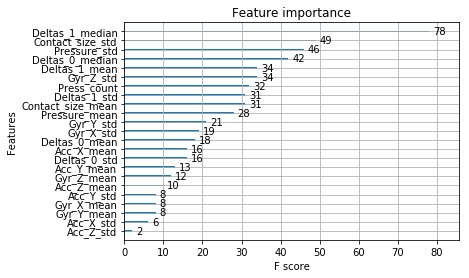

In [1100]:
xgb.plot_importance(clf)
plt.figure()

In [1075]:
df_test.reset_index().SessionID.unique()

array(['Diego02', 'Toto9', 'jo4'], dtype=object)

In [1076]:
df_train.reset_index().SessionID.unique()

array(['Andres1', 'Diego01', 'Diego03', 'Diego04', 'Jo1', 'Toto1', 'Toto2',
       'Toto5', 'Toto6', 'Toto7', 'Toto8', 'jo2', 'jo3'], dtype=object)